In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

from skimage import  morphology, filters, color, measure
size = (4,4)

In [2]:
sudoku = os.path.join(os.getcwd(), 'sudoku')
files = [os.path.splitext(x) for x in os.listdir(sudoku)]

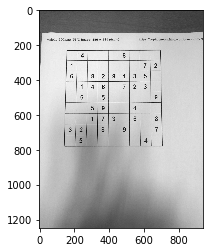

In [3]:
img = cv2.imread(os.path.join('sudoku', 'igorsm1-1.png'), cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=size)
plt.imshow(img, interpolation="none", cmap="gray")
plt.show()

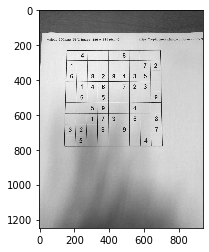

In [19]:




def contrast(img):
    clahe = cv2.createCLAHE(clipLimit=0.2, tileGridSize=(15,15))
    return clahe.apply(img)


img_clahe = contrast(img)
plt.figure(figsize=size)
plt.imshow(img_clahe, interpolation="none", cmap="gray")
plt.show()




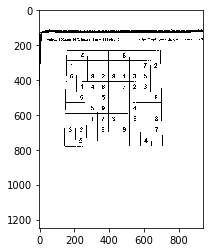

In [20]:
thresh = filters.threshold_local(img_clahe, 91, offset=18)
clean = img_clahe > thresh
plt.figure(figsize=size)
plt.imshow(clean, interpolation="none", cmap="gray")
plt.show()

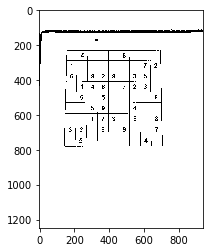

In [21]:
opening = ~morphology.remove_small_objects(~clean, min_size=140)
# opening = morphology.reconstruction(~opening, ~clean)
plt.figure(figsize=size)
plt.imshow(opening , interpolation="none", cmap="gray")
plt.show()

In [22]:
label = morphology.label(opening, connectivity=2)

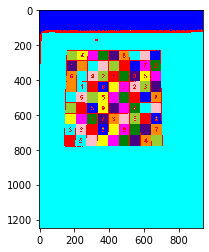

In [23]:
plt.figure(figsize=size)
plt.imshow(color.label2rgb(label), interpolation="none", cmap="gray")
plt.show()

In [24]:
def outliers(data):
    arr = []
    threshold=3
    mean = np.mean(data)
    std =np.std(data)

    for y in data:
        z_score= (y - mean)/std 
        if np.abs(z_score) <= threshold:
            arr.append(y)
    return arr

In [25]:
region = measure.regionprops(label)

In [26]:
areas = []

for obj in region:
    area = obj["area"]
    if area > 20 :
        areas.append(area)
    

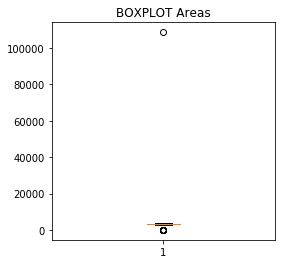

In [27]:
fig, ax = plt.subplots(figsize=size)
ax.set_title('BOXPLOT Areas')
ax.boxplot(outliers(areas))
plt.show()

In [28]:

def select(x):
    q1, q3= np.percentile(areas,[25,75])
    iqr = q3 - q1
    min_area = q1 -(1.5 * iqr) 
    max_area = q3 +(1.5 * iqr)
    
    return[min_area, max_area]

In [29]:
mask = np.zeros_like(opening)


min_area, max_area = select(areas)
boxes = {}
count = 0
for obj in region:
    area = obj["area"]
    
    if (area > min_area and area < max_area):
        bbox = obj.bbox
        mask[bbox[0]:bbox[2],bbox[1]:bbox[3]]|= (obj.filled_image)
        boxes[obj.label] = {}
        boxes[obj.label]['mask'] = opening[bbox[0]:bbox[2],bbox[1]:bbox[3]] & (obj.filled_image)
        # Porcentagem de pixeis preenchidos em cada região
        boxes[obj.label]['filled'] = obj.area/obj.filled_area
        boxes[obj.label]['bbox'] = list(bbox)
        count +=1

        #         imagem |= (label == obj.label)
        

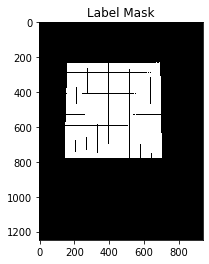

In [30]:
plt.figure(figsize=size)
plt.title("Label Mask")
plt.imshow(mask, interpolation="none", cmap="gray")
plt.show()

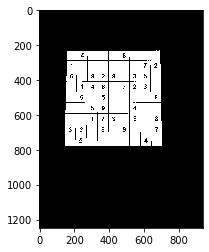

In [31]:
plt.figure(figsize=size)
plt.imshow(mask& opening, interpolation="none", cmap="gray")
plt.show()

In [32]:
points = [[x] + boxes[x]['bbox'] + [boxes[x]['filled']] for x in boxes.keys()]
points = sorted(points, key = lambda y: y[1])
chunks = np.asarray(points).reshape(9,9,6)

def sort(x):
    return sorted(x, key = lambda x: x[2])

matrixM = map(sort, chunks)
matrix = list(matrixM)



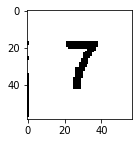

In [33]:
index = matrix[3][5][0].astype(int)
plt.figure(figsize=(2,2))
plt.imshow(boxes[index]['mask'], interpolation="none", cmap="gray", vmin=0, vmax=1)
plt.show()